In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas_datareader.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'google', start, end)
    data=pd.DataFrame(data)
    prices=data['Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [4]:
sess = tf.InteractiveSession()

In [5]:
positions = tf.constant([-1,0,1]) #long, neutral or short
num_positions = 3
num_symbols = len(symbol_list)
num_samples = 20

x = tf.placeholder(tf.float32, [None, num_symbols * 100])
y_ = tf.placeholder(tf.float32, [None,  num_symbols])

W = tf.Variable(tf.random_normal([num_symbols * 100, num_positions * num_symbols]))
b = tf.Variable(tf.random_normal([num_positions * num_symbols]))

y = tf.matmul(x, W) + b 

# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
sample_n = {}
sample_mask = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(num_symbols):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), num_samples)
    # isolate the probability of the selected policy (for use in calculating gradient)
    for sample_iter in range(num_samples):
        sample_n[i*num_samples + sample_iter] = sample[:,sample_iter]
        pos[i*num_samples + sample_iter] = tf.reshape(sample_n[i*num_samples + sample_iter], [-1]) - 1
        symbol_returns[i*num_samples + sample_iter] = tf.multiply(
                                                            tf.cast(pos[i*num_samples + sample_iter], float32), 
                                                             y_[:,i])
        
        sample_mask[i*num_samples + sample_iter] = tf.cast(tf.reshape(tf.one_hot(sample_n[i*num_samples + sample_iter], 3), [-1,3]), float32)
        relevant_target_column[i*num_samples + sample_iter] = tf.reduce_sum(
                                                    symbol_probs_softmax * sample_mask[i*num_samples + sample_iter],1)
    


daily_returns_by_symbol_ = tf.concat(axis=1, values=[tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns_by_symbol = tf.transpose(tf.reshape(daily_returns_by_symbol_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]
daily_returns = tf.reduce_mean(daily_returns_by_symbol, 2) # [?,5]

total_return = tf.reduce_prod(daily_returns+1, 0)
z = tf.ones_like(total_return) * -1
total_return = tf.add(total_return, z)


ann_vol = tf.multiply(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns, 0)),2),0)) ,
    np.sqrt(252)
    )
sharpe = tf.div(total_return, ann_vol)
#Maybe metric slicing later
#segment_ids = tf.ones_like(daily_returns[:,0])
#partial_prod = tf.segment_prod(daily_returns+1, segment_ids)


training_target_cols = tf.concat(axis=1, values=[tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
ones = tf.ones_like(training_target_cols)
gradient_ = tf.nn.sigmoid_cross_entropy_with_logits(labels=training_target_cols, logits=ones)
gradient = tf.transpose(tf.reshape(gradient_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]

#cost = tf.multiply(gradient , daily_returns_by_symbol_reshaped)
#cost = tf.multiply(gradient , tf.expand_dims(daily_returns, -1))
cost = tf.multiply(gradient , tf.expand_dims(total_return, -1))
# cost = tf.multiply(gradient , tf.expand_dims(sharpe, -1))

optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
costfn = tf.reduce_mean(cost)






In [6]:
# initialize variables to random values
init = tf.global_variables_initializer()
sess.run(init)
# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(2000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,75)
    end = min(train_size, start+batch_size)
    
    sess.run(optimizer, feed_dict={x: train_ins[start:end], y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%100== 0:
        t,s, c = sess.run([ total_return, sharpe, costfn], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        t = np.mean(t)
        s = np.mean(s)
        print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
             "sharpe=", "{:.9f}".format(s))
        #print(t)

Epoch: 0100 cost= 1.48023 total return= 3.557313919 sharpe= 2.085654259
Epoch: 0200 cost= 1.81074 total return= 4.276563644 sharpe= 2.507260799
Epoch: 0300 cost= 2.07541 total return= 4.851496696 sharpe= 2.844292164
Epoch: 0400 cost= 1.42713 total return= 3.589344025 sharpe= 2.102812290
Epoch: 0500 cost= 1.34209 total return= 3.339767456 sharpe= 1.959243417
Epoch: 0600 cost= 1.50117 total return= 3.775519609 sharpe= 2.214963436
Epoch: 0700 cost= 1.57011 total return= 3.965950012 sharpe= 2.326948643
Epoch: 0800 cost= 1.33224 total return= 3.598165035 sharpe= 2.109631062
Epoch: 0900 cost= 0.706881 total return= 1.877704620 sharpe= 1.100140810
Epoch: 1000 cost= 0.761505 total return= 2.024359941 sharpe= 1.185175061
Epoch: 1100 cost= 0.911471 total return= 2.437183142 sharpe= 1.425802827
Epoch: 1200 cost= 1.6589 total return= 4.489245892 sharpe= 2.627991199
Epoch: 1300 cost= 1.89802 total return= 5.195552349 sharpe= 3.041148186
Epoch: 1400 cost= 1.84092 total return= 5.077595711 sharpe= 2.

In [7]:
# in sample results
#init = tf.initialize_all_variables()
#sess.run(init)
d, t = sess.run([daily_returns, total_return], feed_dict={x: train_ins, y_: train_outs})

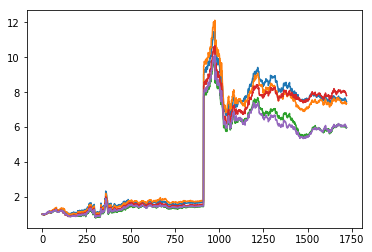

In [8]:
# equity curve
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))

In [9]:
#out of sample results
d, t = sess.run([daily_returns, total_return], feed_dict={x: test_ins, y_: test_outs})

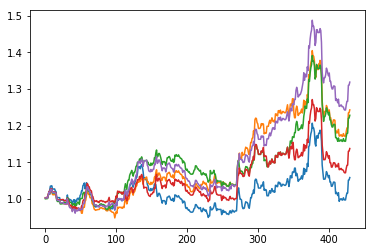

In [10]:
#out of sample results
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))